In [394]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn import metrics

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import math 
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution
from torch.distributions import Bernoulli, Normal
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.autograd import Variable
from tqdm import tqdm
import torch.nn as nn
import torch.functional as F
import torch.distributions as dist


transform_to_tensor = ToTensor()
#transform_to_tensor(images[0]).shape

In [395]:
p = Bernoulli(logits=torch.zeros((1000,)))


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        eps = torch.empty_like(self.mu).normal_()
        return self.mu + self.sigma * eps
    
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return - ((z - self.mu)**2)/(2*self.sigma**2) - torch.log(self.sigma) - math.log(math.sqrt(2 * math.pi)) # <- your code
    
    def mu(self):
        return(self.mu, self.sigma)

In [401]:
class SynthNN(nn.Module):
    def __init__(self, hidden_size = 6):
        super().__init__()
        self.function = nn.Sequential(
            nn.Linear(in_features=2, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=10),
        )
        # self.function = nn.Sequential(
        #     nn.Linear(in_features = 2, out_features = 10),
        #     nn.ReLU()
        # )
        # self.function = nn.Linear(in_features = 2, out_features = 10)

    def forward(self, Z):
        return self.function(Z)


def simulate_synthetic_data(samples, function):
    envs1 = np.array([0.2, 2, 3, 5])
    E = np.random.choice([0,1,2,3], size = samples)

    env = envs1[E]
    Z1 = env + np.random.normal(0, 1, size = samples)
    Z2 = 2*env + np.random.normal(0, np.sqrt(2), size = samples)
    Y = Z1 + Z2 + np.random.normal(0, 1, size = samples)
    # Z3 = Y + env + np.random.normal(0, 1, size = samples)
    Z = np.stack([Z1, Z2], axis = 1)

    if function == 'identity':
        X = Z
    elif function == 'linear':
        S = np.random.normal(size = (2,10))
        X = Z@S
    elif function == 'nonlinear':
        synthnn = SynthNN()
        X = synthnn(torch.tensor(Z).float()).detach().numpy()
    
    return X, Y, E, Z, env

class EnvDataset(Dataset):
    def __init__(self, X, Y, E):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y).unsqueeze(1)
        E = torch.tensor(E)
        self.E = torch.nn.functional.one_hot(E.long())
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.E[index] 
    
    def __len__(self):
        return(len(self.X))
        
model = SynthNN()

In [399]:
#Generate data
torch.manual_seed(1)
X, Y, envs, Z, E = simulate_synthetic_data(8000, 'nonlinear')
dset = EnvDataset(X[:4000],Y[:4000],envs[:4000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset1 = EnvDataset(X[4000:],Y[4000:],envs[4000:])
test_loader = DataLoader(dset1, batch_size=128, drop_last=True)


# Load a batch of images into memory
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]
environment = sample[2]

# NF-IVAE for synthetic data

In [402]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class NF_iVAE(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(NF_iVAE, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features

        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        ## setting the prior to a vector consisting of zeros with dimensions (1,2*latent_features)
        # self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
        '''
        According to page 31-32 the iVAE consist of 7 NNs:
        1. TNN prior
        2. lambdaNN prior
        3. lambdaf prior
        
        4. X-encoder (Classic image CNN)
        5. (Y, E)-encoder
        6. (X, Y, E)-merger/encoder

        7. Decoder

        1-3: Learn priors based on the label distribution for the given environment
        4-6: Encoding X, encoding Y and E and merging these two encoders, to generate a 
             qz which is conditional on the environment.
        7: Decodes the latent space through pz. Since the latent space now contain some measure
           of environment, then this distribution pz is consequentially conditioned on the environment

        NN 1-3 can be found in the variational inference funktion.
        '''
        ####
        #1/8
        # self.Lambdaflinear_prior = nn.Sequential(
        #     nn.Linear(in_features = 2, out_features = 50),
        #     nn.Linear(in_features = 50, out_features = 4)
        # )


        #2/8
        self.Lambdafnl_prior = nn.Sequential(
            nn.Linear(in_features = 5, out_features = 6),
            # nn.Linear(in_features = 5, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 2*latent_features)
        )

        #3/8
        self.TNN_prior = nn.Sequential(
            nn.Linear(in_features = latent_features, out_features = 6),
            # nn.Linear(in_features = 2, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = latent_features)
        )

        #4/8
        self.LambdaNN_prior = nn.Sequential(
            nn.Linear(in_features = 5, out_features = 6),
            # nn.Linear(in_features = 5, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 1)
        )

        #5/8
        # self.LinearEncoder = nn.Sequential(
        #     nn.Linear(in_features = latent_features, out_features = 50),
        #     nn.Linear(in_features = 50, out_features = 3)
        # )

        #6/8
        self.NonLinearEncoder = nn.Sequential(
            nn.Linear(in_features = 15, out_features = 6),
            # nn.Linear(in_features = 15, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features = 2*latent_features)
        )

        #7/8
        # self.LinearDecoder = nn.Sequential(
        #     nn.Linear(in_features = latent_features, out_features = 50),
        #     nn.Linear(in_features = 50, out_features = 2),
        # )

        #8/8
        self.NonLinearDecoder = nn.Sequential(
            nn.Linear(in_features = latent_features, out_features = 6),
            # nn.Linear(in_features = 2, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 10),
        )

        self.relu = nn.ReLU()
        

    #Funktion fra Thea, ved ikke helt hvor hun har den fra - ligner dog equation (2)
    def prior_pdf(self, z, TNN_parameters, lambdaNN_parameters, lambdafnl_parameters, reduce = True):
        #beregning fra side 28 under M.2. P_T,lambda(Z|Y,E).
        nn = (TNN_parameters*lambdaNN_parameters).sum(dim = 1) #prikprodukt
        z_cat = torch.cat((z, z.pow(2)), dim = 1) 
        f = (z_cat * lambdafnl_parameters).sum(dim = 1) #prik produkt
        return nn + f

    def prior_params(self, z, y, e):
        """return the distribution `p(z)`"""
        TNN_parameters = self.TNN_prior(z)
        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        LambdaNN_parameters = self.LambdaNN_prior(ye)
        lambdafnl_parameters = self.Lambdafnl_prior(ye)

        return TNN_parameters, LambdaNN_parameters, lambdafnl_parameters

    #NN 4/7
    def encoder(self, x, y, e):

        #x = relu(self.encoderCNN1(x))
        #x = relu(self.encoderCNN2(x))
        #x = relu(self.encoderCNN3(x))
        #x = x.view(x.size(0), -1) #NN 4/7
        
        #ye = torch.cat((y, e), dim = 1)
        # ye = ye.to(torch.float32)
        # ye = self.YEencoder(ye) #NN 5/7

        xye = torch.cat((x,y,e), dim = 1)
        #print(xye.size())
        xye = self.NonLinearEncoder(xye)
        # xye = self.XYEmerger(xye) #NN 6/7
        #mu, log_sigma =  x.chunk(2, dim=-1)
        
        return xye
   
    #NN 7/7
    def decoder(self, z):
        x = self.NonLinearDecoder(z)
        return x

     #Non-factorized prior for NF-iVAE from page 28
    def non_factorized_prior_pz(self, z, TNN_parameters, lambdaNN_parameters, lambdaf_parameters, reduce = True):
        #beregning fra side 28 under M.2. P_T,lambda(Z|Y,E).
        z_cat = torch.cat((z, z.pow(2)), dim = 1) 
        # "(*).sum(dim=1)" is the vector-vector dot product. It is not possible to make this calculation with e.g. torch.tensordot, as we want the dot product of each vector and not the entire batch
        non_factorized_prior = (TNN_parameters*lambdaNN_parameters).sum(dim = 1) + (z_cat * lambdaf_parameters).sum(dim = 1)
        #the f,z term - (z_cat * lambdaf_parameters).sum(dim = 1): Is equivalent to the factorized exponential family
        #the NN term - (TNN_parameters*lambdaNN_parameters).sum(dim = 1): Capture the dependencies between the latent variables
        return non_factorized_prior

    def parameters_for_non_factorized_prior(self, z, y, e):
        """return the distribution `p(z)`"""
        TNN_parameters = self.TNN_prior(z)
        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        LambdaNN_parameters = self.LambdaNN_prior(ye)
        lambdaf_parameters = self.Lambdafnl_prior(ye)

        return TNN_parameters, LambdaNN_parameters, lambdaf_parameters
        
    def posterior(self, x:Tensor, y:Tensor, e:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x, y, e)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        #print(z.size())
        px_loc = self.decoder(z)
        shape = torch.ones(px_loc.shape)
        shape = 0.1 * shape 
        #print(px_loc.size())
        #px_loc = px_loc.view(-1, *self.input_shape) # reshape the output #old
        #sandsynlighedsfordeling der giver 1 eller 0, baseret p� log-odds givet i logits input fra p(x|z).
        #Dvs. at px_logits angiver sandsynligheden for at det givne pixel er henholdsvist r�d,gr�n,bl�. Pixel v�rdien
        #er enten 0 eller 1. N�r man sampler fra bernoulli fordelingen f�s dermed et billede, som givet z, giver en figur,
        #som er bestemt af de sandsynligheder der er i px_logits (p(x|z)). Dvs. at for et givet latents space, kan en
        #figur/et tal reproduceres ud fra de beregnede sandsynligheder og den efterf�lgende sample fra Bernoulli fordelingen.
        #return Bernoulli(logits=px_loc, validate_args=False)
        return Normal(loc=px_loc, scale = shape)
        

    def forward(self, x, y, e) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        #### Run through ENCODER and calculate mu and sigma for latent space sampling
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x, y, e)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        #### LATENT SPACE
        z = qz.rsample()
        
        #### DECODER
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'qz': qz, 'z': z}

    def reduce(self, x:Tensor) -> Tensor:
        """for each datapoint: sum over all dimensions"""
        return x.view(x.size(0), -1).sum(dim=1)

    def VariationalInference(self, x, y, e):
        
        # forward pass through the model to get the encoder and decoder outputs
        parameters_and_latent_space = self.forward(x, y, e)

        # unpack encoder parameters from (px), decoder parameters (qz) and the latent space (z)
        px_ze, qz_xye, z = [parameters_and_latent_space[k] for k in ["px", "qz", "z"]]


        # DEFINE THE PRIOR p(z)
        #### PRIOR
        z_temp = z.detach().requires_grad_(requires_grad = True)
        y_temp = y.detach()
        e_temp = e.detach()
        TNN_parameters, LambdaNN_parameters, lambdaf_parameters = self.parameters_for_non_factorized_prior(z_temp, y_temp, e_temp) #bruger temp da priors træning ikke skal påvirke encoder og decoder

        #prior calculation from page 28 (til differentiering ifm. eq. 64 skal dette ikke være logget, men når
        # elbo loss beregnes, skal man huske at tage log at denne værdi jvf. p. 28)

        #According to page 6. equation (8)-(10)
        TNN_parameters_hat = TNN_parameters.detach()
        LambdaNN_parameters_hat = LambdaNN_parameters.detach()
        lambdaf_parameters_hat = lambdaf_parameters.detach()

        log_pz_ye_ELBO =  self.non_factorized_prior_pz(z, TNN_parameters_hat, LambdaNN_parameters_hat, lambdaf_parameters_hat)
        log_pz_ye_SM = self.non_factorized_prior_pz(z_temp, TNN_parameters, LambdaNN_parameters, lambdaf_parameters) #phi_hat (or phi.detach()) from page. 6 is implemented implicitly/auto-
        #matically through the implementation of SM on page 28 eq. (64), where autograd of p_T,lambda is used instead of the conditional distribution q_phi(Z|X,Y,E), here phi
        #is evidently excluded from the gradient calculation.
        #OBS: HER SKAL DER IKKE ANVENDES LOG-PROBS AF PZ_YE JVF. SM DELEN AF EQ. (64) PÅ SIDE 28... eller hvad???
        dpdz_ye = torch.autograd.grad(log_pz_ye_SM.sum(), z_temp, create_graph = True, retain_graph=True)[0]

        #ddpz_ye = torch.autograd.grad(dpz_ye.mean(), z_temp, create_graph = True, retain_graph=True)[0] #changed sum() to mean()
        ddpdz_sq_ye = torch.autograd.grad(dpdz_ye.sum(), z_temp, create_graph = True, retain_graph=True)[0] #original

        #### SM loss SM loss SM loss SM loss SM loss SM loss SM loss SM loss ####
        #Calculation from page 28 equation 64
        SM = (ddpdz_sq_ye + 0.5 * dpdz_ye.pow(2)).sum(1)
        #### SM loss SM loss SM loss SM loss SM loss SM loss SM loss SM loss ####

        #### ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ELBO loss ####
        # evaluate log probabilities
        # Skal jvf. s. 32 ændres til at være en normal fordeling i stedet for en
        # bernoulli fordeling, og her skal mean være outputtet af decoderen og varians skal
        #blot sættes til at være 0.01
        
        log_px_ze = self.reduce(px_ze.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        
        ####(old)log_pz = reduce(pz.log_prob(z)) #log(p(z)): 
        #log_pz_ye = torch.log(pz_ye)#Sandsynligheden for at observere vores latent space, givet at
        #latent space følger en standard-normal fordeling (Jo højere sandsynlighed jo bedre)
        
        log_qz_xye = self.reduce(qz_xye.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne værdi skal helst være lav?
        
        # compute the ELBO: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Forsøger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        
        kl = log_qz_xye - log_pz_ye_ELBO
        
        elbo = log_px_ze - kl
        ####
        
        # loss
        loss = -(elbo.mean() - SM.mean())
        #print("SM: {}. elbo: {} = log_px_ze: {} + log_pz_ye: {} - log_qz_xye: {}".format(SM.mean(), elbo.mean(),log_px_ze.mean(),pz_ye.mean(),log_qz_xye.mean()))

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px_ze, 'kl': kl}
        
        outputs = parameters_and_latent_space
        return loss, diagnostics, outputs

latent_features = 2 #Husk at opdater denne parameter nede i 'initialization', hvis den skal bruges i VAE loopet ogs�
batch_size = 128
nf_ivae = NF_iVAE(images[0].shape, latent_features)
print(nf_ivae)

NF_iVAE(
  (Lambdafnl_prior): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
  )
  (TNN_prior): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=2, bias=True)
  )
  (LambdaNN_prior): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
  (NonLinearEncoder): Sequential(
    (0): Linear(in_features=15, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
  )
  (NonLinearDecoder): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=10, bias=True)
  )
  (relu): ReLU()
)


In [403]:
# device = torch.device("cpu")
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]#.reshape(-1,1)
environment = sample[2]#.reshape(-1,1)

x = images
y = label
e = environment

loss, diagnostics, outputs = nf_ivae.VariationalInference(x.float(), y.float(), e.float())
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    211.876, shape: []
elbo   | mean =   -202.998, shape: [128]
log_px | mean =   -202.559, shape: [128]
kl     | mean =      0.439, shape: [128]


In [404]:
from collections import defaultdict
# define the models, evaluator and optimizer

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f">> Using device: {device}")

# VAE
latent_features = 2 #Hyper parameter
nf_ivae = NF_iVAE(images[0].shape, latent_features)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(nf_ivae.parameters(), lr=1e-3) #Hyper parameter, tilf�j evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

torch.manual_seed(1)
num_epochs = 500 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

# move the model to the device
# nf_ivae = nf_ivae.to(device)
sample_counter = 0
# training..
for i in tqdm(range(num_epochs)):
    # epoch+= 1
    training_epoch_data = defaultdict(list)
    nf_ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        sample_counter += 1
        
        x = sample[0]
        x = x.to(device)

        y = sample[1]#.reshape(-1,1)
        y = y.to(device)

        e = sample[2]#.reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = nf_ivae.VariationalInference(x.float(), y.float(), e.float())
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # px = outputs['px']
    # samples = px.sample()


>> Using device: cpu


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


In [425]:
import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt

nf_ivae.eval()

loader = DataLoader(dset1, batch_size=4000)
sample = next(iter(loader))

x = sample[0]
y = sample[1]#.reshape(-1,1)
e = sample[2]#.reshape(-1,1)

output = nf_ivae.forward(x.float(), y.float(), e.float())

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

enviro = np.zeros((len(e_full),1))
for i in range(0,4):
    inde = e_full[:,i] == 1
    enviro[inde] = i+1

z_df = pd.DataFrame(z_full.detach())
y_df = pd.DataFrame(y_full.detach())
e_df = pd.DataFrame(enviro)

df = z_df; df['Y'] = y_df
df.columns = ['Z1', 'Z2', 'Y']

df = df[['Y','Z1','Z2']]

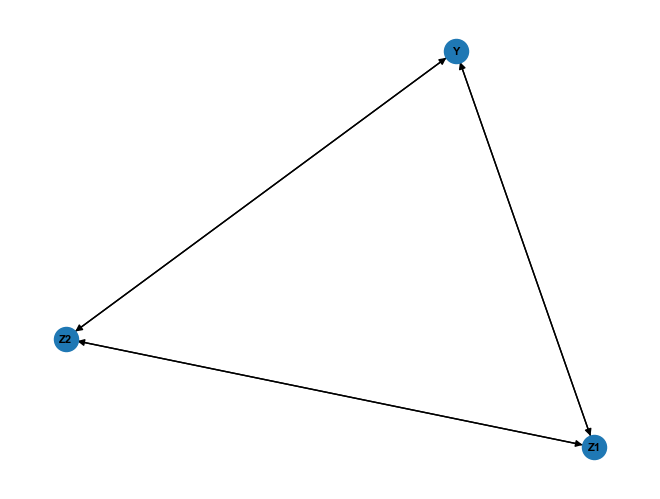

In [412]:
loader1 = DataLoader(dset, batch_size=4000)
sample1 = next(iter(loader1))

x1 = sample1[0]
y1 = sample1[1]#.reshape(-1,1)
e1 = sample1[2]#.reshape(-1,1)

output1 = nf_ivae.forward(x1.float(), y1.float(), e1.float())

z1 = output1['z']

z_full1 = z1
x_full1 = x1
y_full1 = y1
e_full1 = e1

enviro1 = np.zeros((len(e_full1),1))
for i in range(0,4):
    inde1 = e_full1[:,i] == 1
    enviro1[inde1] = i+1

z_df1 = pd.DataFrame(z_full1.detach())
y_df1 = pd.DataFrame(y_full1.detach())
e_df1 = pd.DataFrame(enviro1)

df1 = z_df1; df1['Y'] = y_df1
df1.columns = ['Z1', 'Z2', 'Y']

# df1 = df1[['Y','Z1','Z2']]

pc = PC(alpha = 1e-3)
pc_output = pc.predict(df1)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

In [426]:
# To ensure correct coloring we re-run the coloring
df['E'] = e_df
colors = []

for col in df["E"]:
    if col == (1.0):
        colors.append("red")
    elif col == (2.0):
        colors.append("green")
    elif col == (3.0):
        colors.append("blue")
    elif col == (4.0):
        colors.append("orange")

df["colour"] = colors

colors = np.array(["r", "g", "b", "y"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


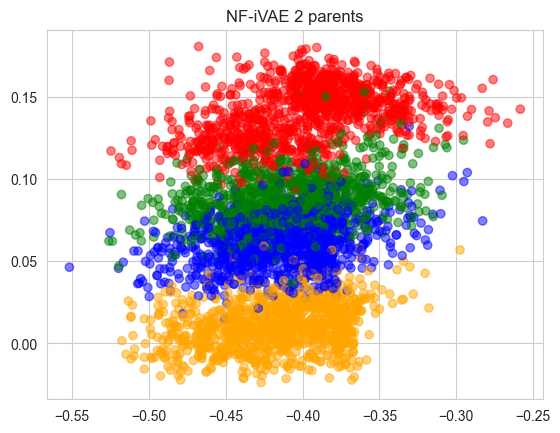

In [427]:

plt.scatter(df["Z1"], df["Z2"], c=df["colour"]).set_alpha(0.5)
# plt.title("NFivae, 2parents 1child")
# plt.axis("off");
plt.title("NF-iVAE 2 parents"); plt.show()
# plt.savefig('Z1Z2_NFiVAE.png', transparent=True)

# iVAE for synthetic data

In [415]:
class iVariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int, device) -> None:
        super(iVariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features

        self.device = device

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        ## setting the prior to a vector consisting of zeros with dimensions (1,2*latent_features)
        # self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
        '''
        According to page 31-32 the iVAE consist of 7 NNs:
        1. lambdaf prior
        
        2. X-encoder (Classic image CNN)
        3. (Y, E)-encoder
        4. (X, Y, E)-merger/encoder

        5. Decoder

        1: Learn priors based on the label distribution for the given environment
        2-4: Encoding X, encoding Y and E and merging these two encoders, to generate a 
             qz which is conditional on the environment.
        5: Decodes the latent space through pz. Since the latent space now contain some measure
           of environment, then this distribution pz is consequentially conditioned on the environment

        NN 1-3 can be found in the variational inference funktion.
        '''
        #### PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS ####
        #NN 1/5
        self.Lambdaf_prior = nn.Sequential(
            nn.Linear(in_features = 5, out_features = 6),
            # nn.Linear(in_features = 5, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 2*latent_features)
            )  #Output
        #### PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS PRIORS ####

         #For NN 2/5 X-Encoder: Inference Network
         #Encode the observation `x` into the parameters of the posterior distribution
         #`q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        ##NN 3/5 (Y, E)-Encoder
        self.NonLinearEncoder = nn.Sequential(
            nn.Linear(in_features = 15, out_features = 6),
            # nn.Linear(in_features = 15, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features=6, out_features = 2*latent_features)
        )

        self.NonLinearDecoder = nn.Sequential(
            nn.Linear(in_features = latent_features, out_features = 6),
            # nn.Linear(in_features = 2, out_features = 128),
            # nn.Linear(in_features = 128, out_features = 6),
            nn.ReLU(),
            nn.Linear(in_features = 6, out_features = 10),
        )

        ##NN 4/5 (X, Y, E)-merger/encoder
        #remember to concatenate x.flatten, y, e before running this.
        # self.XYEmerger = nn.Sequential(
        #     nn.Linear(in_features = 32 * 4 * 4 + 100, out_features=100),
        #     nn.Linear(in_features = 100, out_features = 100),
        #     nn.ReLU(),
        #     nn.Linear(in_features = 100, out_features = 2*latent_features))


        #For NN 5/5 (Decoder): Generative Model
        #Decode the latent sample `z` into the parameters of the observation model
        #`p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`

    def prior_params(self, y, e):
        """return the distribution `p(z)`"""
        ye = torch.cat((y, e), dim = 1)
        ye = ye.to(torch.float32)
        lambdaf_parameters = self.Lambdaf_prior(ye)

        return lambdaf_parameters

    #NN 4/7
    def encoder(self, x, y, e):

        xye = torch.cat((x,y,e), dim = 1)

        xye = self.NonLinearEncoder(xye) #NN 6/7
    
        return xye
   
    #NN 7/7
    def decoder(self, z):
        
        x = self.NonLinearDecoder(z)
        return x    
        
    def posterior(self, x:Tensor, y:Tensor, z:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x, y, z)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, y, e)-> Distribution:
        """return the distribution `p(z)`"""
        #Expand prior_params til at være samme antal rækker som i den valgte batch size således at der fås
        #en tensor med dimensionerne (batch_size, 2*latent_features), som så kan udfyldes med
        prior_params = self.prior_params(y, e)
        #chunk opdeler prior_params i to dele, de første 0-latent_features kollonner indeholder mu og 
        #de sidste n_latent_features inde holder sigmaerne. Nu er der to tensors, som begge har dim
        #(batch_size, n_latent_features). Værdierne i disse tensors, kan bruges til at sample hvordan
        #latent space ser ud (Den der hedder 'latent interpolations' i plots i bunden.)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        #BEMÆRK at at det er log_sigma, dvs. at når den inputtes i ReparameterizedDiagonalGaussian så fås mu = 0, sigma = 1
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_means = self.decoder(z)
        px_means = px_means.view(-1, *self.input_shape) # reshape the output #old
        log_var = 0.01 * torch.ones(px_means.shape)
        log_sigma = torch.log(torch.sqrt(log_var))
        log_sigma = log_sigma.to(self.device)
        #sandsynlighedsfordeling der giver 1 eller 0, baseret på log-odds givet i logits input fra p(x|z).
        #Dvs. at px_logits angiver sandsynligheden for at det givne pixel er henholdsvist rød,grøn,blå. Pixel værdien
        #er enten 0 eller 1. Når man sampler fra bernoulli fordelingen fås dermed et billede, som givet z, giver en figur,
        #som er bestemt af de sandsynligheder der er i px_logits (p(x|z)). Dvs. at for et givet latents space, kan en
        #figur/et tal reproduceres ud fra de beregnede sandsynligheder og den efterfølgende sample fra Bernoulli fordelingen.
        return ReparameterizedDiagonalGaussian(mu = px_means, log_sigma = log_sigma)
        

    def forward(self, x, y, e) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        ###############################################################################################
        # flatten the input
        #x = x.view(x.size(0), -1) #outcommented as part of adding CNN
        
        #### Run through ENCODER and calculate mu and sigma for latent space sampling
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x, y, e)
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        #### LATENT SPACE
        z = qz.rsample()
        
        #### DECODER
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        ###############################################################################################
        
        # define the prior p(z)
        #(Indgår i beregning af kl-term (regularisering) ifm. ELBO) - og bruges også til interpolations visualisering
        #til sidst.
        pz = self.prior(y,e)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, y, e):
        """sample z~p(z) and return p(x|z)"""
        
        # Laver bare reconstruction baseret på latent space
        #Kan evt. fjernes. Anvendes bare til at vise hvor god modellen er til at generere data baseret på
        #latent space genererede data. Funktionen anvendes kun i make_vae_plots.
        
        # degine the prior p(z)
        pz = self.prior(y, e)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}
    
    def reduce(self, x:Tensor) -> Tensor:
        """for each datapoint: sum over all dimensions"""
        return x.view(x.size(0), -1).sum(dim=1)

    def VariationalInference(self, x, y, e, beta):
        self.beta = beta
        # forward pass through the model
        outputs = self.forward(x, y, e)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = self.reduce(px.log_prob(x)) #log(p(x|z)): Sandsynligheden for at observere vores input variabel x
        #givet vores latent space (tjekker modellens evne til at rekonstruere sig selv, ved at maximere sandsynlig-
        #heden for at observere inputtet selv, givet det konstruerede latent space.
        log_pz = self.reduce(pz.log_prob(z)) #log(p(z)): Sandsynligheden for at observere vores latent space, givet at
        #latent space følger en standard-normal fordeling (Jo højere sandsynlighed jo bedre)
        log_qz = self.reduce(qz.log_prob(z)) #log(q(z|x)): Sandsynligheden for at generere netop dette latent space givet 
        #vores input billede x. Denne værdi skal helst være lav?
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        #########################################################################################################
        # Reconstruction loss: E_q [ log p(x|z) ]
        # Regularization term: \beta * D_KL(q(z|x) | p(z))` => Forsøger at tvinge fordelingen q(z|x) mod N(0,1)?
        #########################################################################################################
        kl = log_qz - log_pz
        elbo = log_px - kl
        beta_elbo = log_px - self.beta * kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f">> Using device: {device}")

latent_features = 2 #Husk at opdater denne parameter nede i 'initialization', hvis den skal bruges i VAE loopet også
ivae = iVariationalAutoencoder(images[0].shape, latent_features, device)
# ivae = ivae.to(device)
print(ivae)

>> Using device: cpu
iVariationalAutoencoder(
  (Lambdaf_prior): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (NonLinearEncoder): Sequential(
    (0): Linear(in_features=15, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=4, bias=True)
  )
  (NonLinearDecoder): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=10, bias=True)
  )
)


In [416]:
# device = torch.device("cpu")
sample = next(iter(train_loader))
images = sample[0]
label = sample[1]#.reshape(-1,1)
environment = sample[2]#.reshape(-1,1)

x = images
y = label
e = environment

loss, diagnostics, outputs = ivae.VariationalInference(x.float(), y.float(), e.float(),beta = 1)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    241.654, shape: []
elbo   | mean =   -241.654, shape: [128]
log_px | mean =   -238.535, shape: [128]
kl     | mean =      3.119, shape: [128]


In [417]:
from collections import defaultdict
# define the models, evaluator and optimizer

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f">> Using device: {device}")

# VAE
latent_features = 2 #Hyper parameter
# ivae = iVariationalAutoencoder(images[0].shape, latent_features,device)
# ivae = ivae.to(device)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(ivae.parameters(), lr=1e-3) #Hyper parameter, tilf�j evt. weight_decay (L2 regularization)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

torch.manual_seed(1)
num_epochs = 500 #hyper parametre
#batch size hyper parameter can be changed in the dataloader in the beginning.

# move the model to the device
# nf_ivae = nf_ivae.to(device)
sample_counter = 0
# training..
for i in tqdm(range(num_epochs)):
    # epoch+= 1
    training_epoch_data = defaultdict(list)
    ivae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for sample in train_loader:
        sample_counter += 1
        
        x = sample[0]
        x = x.to(device)

        y = sample[1]#.reshape(-1,1)
        y = y.to(device)

        e = sample[2]#.reshape(-1,1)
        e = e.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        optimizer.zero_grad()
        loss, diagnostics, outputs = ivae.VariationalInference(x.float(), y.float(), e.float(),beta = 1)
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # px = outputs['px']
    # samples = px.sample()


>> Using device: cpu


100%|██████████| 500/500 [01:34<00:00,  5.29it/s]


In [418]:
import numpy as np
import pandas as pd
import cdt
cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.2.2/bin/Rscript' # this path should point to your own R implementation !
from cdt.causality.graph import PC
import networkx as nx
import matplotlib.pyplot as plt

ivae.eval()

loader = DataLoader(dset1, batch_size=4000)
sample = next(iter(loader))

x = sample[0]
y = sample[1]#.reshape(-1,1)
e = sample[2]#.reshape(-1,1)

output = ivae.forward(x.float(), y.float(), e.float())

z = output['z']

z_full = z
x_full = x
y_full = y
e_full = e

enviro = np.zeros((len(e),1))
for i in range(0,4):
    inde = e[:,i] == 1
    enviro[inde] = i+1

z_df = pd.DataFrame(z.detach())
y_df = pd.DataFrame(y.detach())
e_df = pd.DataFrame(enviro)

df = z_df; df['Y'] = y_df
df.columns = ['Z1', 'Z2', 'Y']

df = df[['Y','Z1','Z2']]

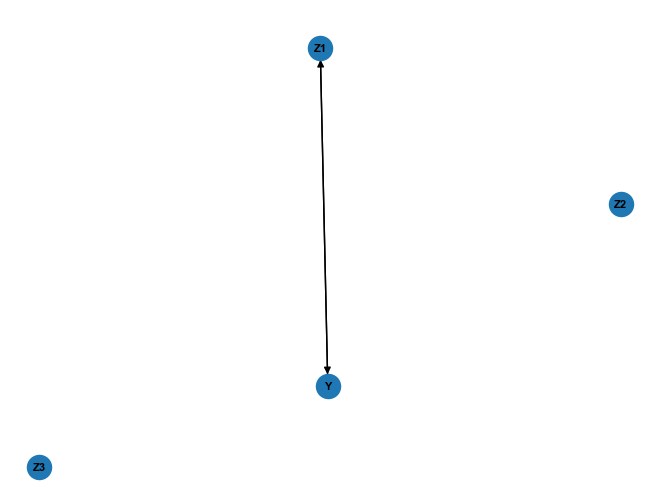

In [342]:
pc = PC(alpha = 1e-10)
pc_output = pc.predict(df)

nx.draw(pc_output, with_labels=True, font_weight='bold', font_size = 8)
plt.show()

In [419]:
# To ensure correct coloring we re-run the coloring
df['E'] = e_df
colors = []

for col in df["E"]:
    if col == (1.0):
        colors.append("red")
    elif col == (2.0):
        colors.append("green")
    elif col == (3.0):
        colors.append("blue")
    elif col == (4.0):
        colors.append("orange")

df["colour"] = colors

colors = np.array(["r", "g", "b", "y"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


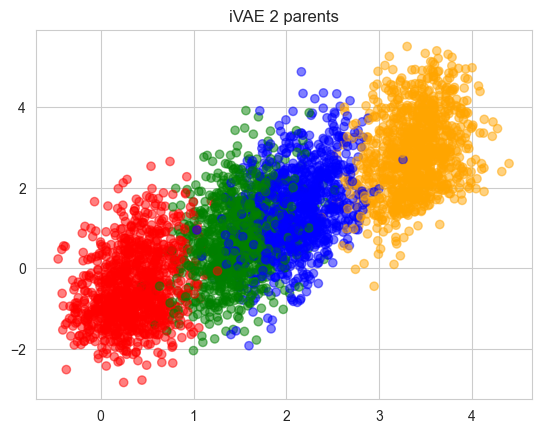

In [424]:

plt.scatter(df["Z1"], df["Z2"], c=df["colour"]).set_alpha(0.5)
plt.title("iVAE 2 parents"); plt.show()
# plt.savefig('Z1Z2_iVAE.png', transparent=True)